# LSTM autoencoder and LSTM

Epoch 1/5
627/627 - 5s - 8ms/step - loss: 6.0842e-04 - val_loss: 1.3101e-05
Epoch 2/5
627/627 - 4s - 6ms/step - loss: 1.3376e-05 - val_loss: 5.2355e-06
Epoch 3/5
627/627 - 4s - 6ms/step - loss: 1.1103e-05 - val_loss: 6.3979e-06
Epoch 4/5
627/627 - 4s - 6ms/step - loss: 1.1326e-05 - val_loss: 3.2030e-06
Epoch 5/5
627/627 - 4s - 6ms/step - loss: 6.9455e-06 - val_loss: 2.7281e-06
784/784 ━━━━━━━━━━━━━━━━━━━━ 1s 863us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
Epoch 1/5


/Library/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


627/627 - 1s - 1ms/step - accuracy: 0.7507 - loss: 0.6062 - val_accuracy: 0.7929 - val_loss: 0.3655
Epoch 2/5
627/627 - 0s - 465us/step - accuracy: 0.7961 - loss: 0.3576 - val_accuracy: 0.7929 - val_loss: 0.3422
Epoch 3/5
627/627 - 0s - 465us/step - accuracy: 0.7949 - loss: 0.3364 - val_accuracy: 0.7881 - val_loss: 0.3165
Epoch 4/5
627/627 - 0s - 467us/step - accuracy: 0.8663 - loss: 0.2963 - val_accuracy: 0.9237 - val_loss: 0.2714
Epoch 5/5
627/627 - 0s - 466us/step - accuracy: 0.9389 - loss: 0.2537 - val_accuracy: 0.9388 - val_loss: 0.2440
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step
Clustering Test Accuracy: 94.15%
Classification Report for LSTM Autoencoder with LSTM Classification:
              precision    recall  f1-score   support

     Crevice       0.90      0.81      0.85      1303
     General       1.00      1.00      1.00      1529
     Passive       0.88      0.94      0.91      1972
     Pitting       1.00      1.00      1.00      1467

    accuracy                       

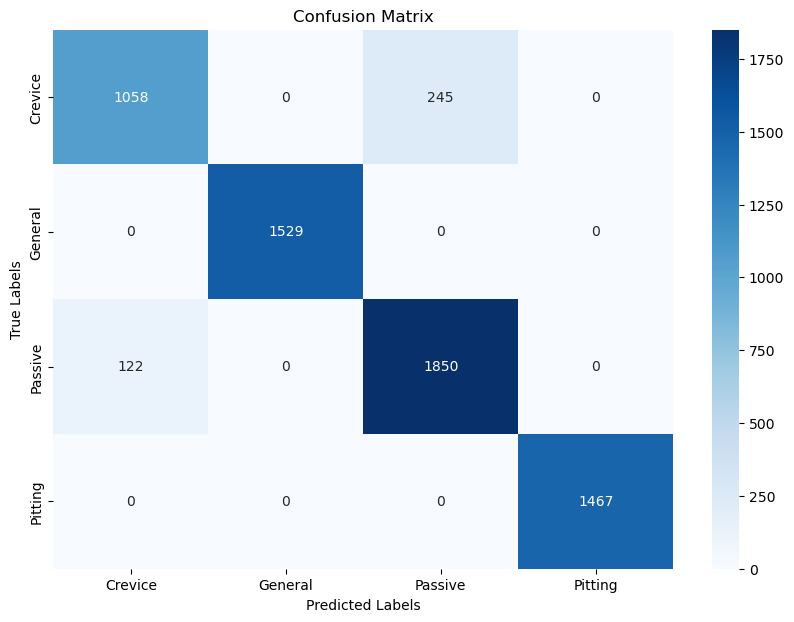

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, LeakyReLU
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import seaborn as sns
from scipy import signal

# Set random seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

# Load the data from CSV file
data = pd.read_csv('For classification-with one passive.csv')

# Extract the input features and labels
current_data = data[['WE(1).Current (A)']].values
potential_data = data[['WE(1).Potential (V)']].values
y = data['Label'].values


current_detrended = signal.detrend(current_data, axis=0)


X_combined = np.hstack([current_detrended, potential_data])

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Create sequences
def create_sequences(data, labels, seq_length):
    X_seq, y_seq = [], []
    for i in range(0, len(data) - seq_length, seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(labels[i + seq_length - 1])
    return np.array(X_seq), np.array(y_seq)

seq_length = 20
X_seq, y_seq = create_sequences(X_combined, y_encoded, seq_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=0)

# Build the LSTM autoencoder model
input_seq = Input(shape=(seq_length, X_train.shape[2]))
encoded = LSTM(50, activation='tanh', return_sequences=False)(input_seq)
decoded = RepeatVector(seq_length)(encoded)
decoded = LSTM(50, activation='tanh', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(X_train.shape[2]))(decoded)

autoencoder = Model(input_seq, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
history = autoencoder.fit(X_train, X_train, epochs=5, batch_size=32, validation_split=0.2, verbose=2)

# Encoder model to extract latent representations
encoder = Model(input_seq, encoded)

# Extract latent representations
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Reshape the latent representations to fit into the LSTM classifier
X_train_encoded_reshaped = X_train_encoded.reshape((X_train_encoded.shape[0], 1, X_train_encoded.shape[1]))
X_test_encoded_reshaped = X_test_encoded.reshape((X_test_encoded.shape[0], 1, X_test_encoded.shape[1]))

# Build the LSTM classifier model
classifier = Sequential()
classifier.add(LSTM(40, activation='tanh', input_shape=(1, X_train_encoded.shape[1])))
classifier.add(Dense(len(np.unique(y_encoded)), activation='softmax'))

classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the LSTM classifier
classifier.fit(X_train_encoded_reshaped, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=2)

# Predict the cluster labels
y_test_pred = classifier.predict(X_test_encoded_reshaped)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Evaluate classification on the test set
accuracy = accuracy_score(y_test, y_test_pred_classes[:len(y_test)])
print(f'Clustering Test Accuracy: {accuracy * 100:.2f}%')
print("Classification Report for LSTM Autoencoder with LSTM Classification:")
print(classification_report(y_test, y_test_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# LSTM autoencoder and RF

Epoch 1/5
627/627 - 4s - 7ms/step - loss: 0.0196 - val_loss: 5.1711e-04
Epoch 2/5
627/627 - 3s - 6ms/step - loss: 4.7361e-04 - val_loss: 1.4771e-04
Epoch 3/5
627/627 - 4s - 6ms/step - loss: 2.4068e-04 - val_loss: 1.3781e-04
Epoch 4/5
627/627 - 3s - 6ms/step - loss: 2.4087e-04 - val_loss: 1.1860e-04
Epoch 5/5
627/627 - 3s - 6ms/step - loss: 1.7472e-04 - val_loss: 1.1581e-04
784/784 ━━━━━━━━━━━━━━━━━━━━ 1s 846us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
Classification Test Accuracy: 97.85%
Classification Report for LSTM Autoencoder with Random Forest Classification:
              precision    recall  f1-score   support

     Crevice       0.96      0.93      0.95      1303
     General       1.00      1.00      1.00      1529
     Passive       0.96      0.98      0.97      1972
     Pitting       1.00      1.00      1.00      1467

    accuracy                           0.98      6271
   macro avg       0.98      0.98      0.98      6271
weighted avg       0.98      0.98      0.98

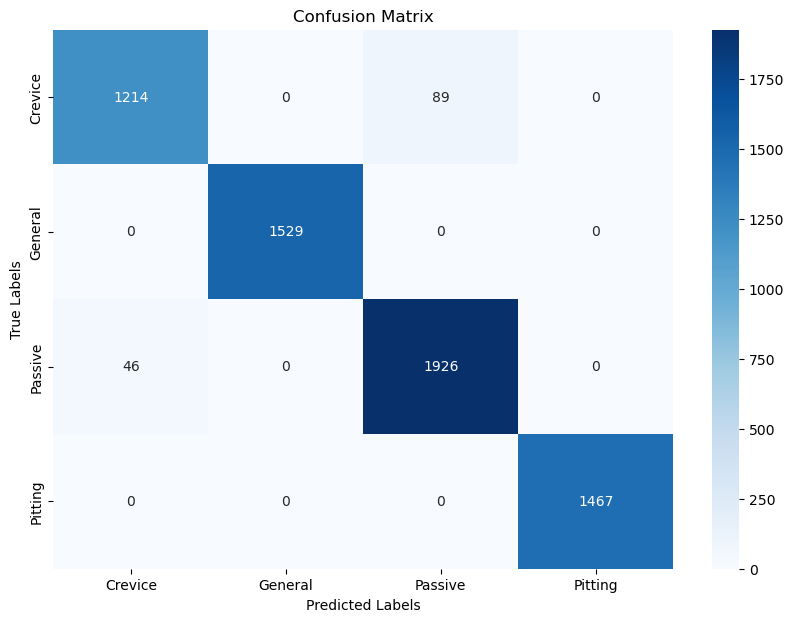

In [14]:
from sklearn.ensemble import RandomForestClassifier


# Set random seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

# Load the data from CSV file
data = pd.read_csv('For classification-with one passive.csv')

# Extract the input features and labels
X = data[['WE(1).Current (A)', 'WE(1).Potential (V)']].values
y = data['Label'].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Create sequences
def create_sequences(data, labels, seq_length):
    X_seq, y_seq = [], []
    for i in range(0, len(data) - seq_length, seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(labels[i + seq_length - 1])
    return np.array(X_seq), np.array(y_seq)

seq_length = 20
X_seq, y_seq = create_sequences(X_scaled, y_encoded, seq_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=0)

# Build the LSTM autoencoder model
input_seq = Input(shape=(seq_length, X_train.shape[2]))
encoded = LSTM(50, activation='tanh', return_sequences=False)(input_seq)
decoded = RepeatVector(seq_length)(encoded)
decoded = LSTM(50, activation='tanh', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(X_train.shape[2]))(decoded)

autoencoder = Model(input_seq, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
history = autoencoder.fit(X_train, X_train, epochs=5, batch_size=32, validation_split=0.2, verbose=2)

# Encoder model to extract latent representations
encoder = Model(input_seq, encoded)

# Extract latent representations
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Flatten the sequences to fit into the Random Forest classifier
X_train_encoded_flat = X_train_encoded.reshape(X_train_encoded.shape[0], -1)
X_test_encoded_flat = X_test_encoded.reshape(X_test_encoded.shape[0], -1)

# Apply Random Forest classification
rf_classifier = RandomForestClassifier(n_estimators=5, random_state=0)
rf_classifier.fit(X_train_encoded_flat, y_train)

# Predict the labels
y_train_pred = rf_classifier.predict(X_train_encoded_flat)
y_test_pred = rf_classifier.predict(X_test_encoded_flat)

# Evaluate classification on the test set
accuracy = accuracy_score(y_test, y_test_pred[:len(y_test)])
print(f'Classification Test Accuracy: {accuracy * 100:.2f}%')
print("Classification Report for LSTM Autoencoder with Random Forest Classification:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# LSTM autoencoder and Simple RNN

Epoch 1/5
627/627 - 5s - 7ms/step - loss: 0.0196 - val_loss: 5.1711e-04
Epoch 2/5
627/627 - 4s - 6ms/step - loss: 4.7361e-04 - val_loss: 1.4771e-04
Epoch 3/5
627/627 - 4s - 6ms/step - loss: 2.4068e-04 - val_loss: 1.3781e-04
Epoch 4/5
627/627 - 4s - 6ms/step - loss: 2.4087e-04 - val_loss: 1.1860e-04
Epoch 5/5
627/627 - 4s - 6ms/step - loss: 1.7472e-04 - val_loss: 1.1581e-04
784/784 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
Epoch 1/5


/Library/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


627/627 - 1s - 1ms/step - accuracy: 0.7908 - loss: 0.4356 - val_accuracy: 0.8294 - val_loss: 0.3401
Epoch 2/5
627/627 - 0s - 393us/step - accuracy: 0.8430 - loss: 0.3386 - val_accuracy: 0.8894 - val_loss: 0.3184
Epoch 3/5
627/627 - 0s - 396us/step - accuracy: 0.8788 - loss: 0.3121 - val_accuracy: 0.8968 - val_loss: 0.2868
Epoch 4/5
627/627 - 0s - 397us/step - accuracy: 0.9011 - loss: 0.2713 - val_accuracy: 0.8954 - val_loss: 0.2480
Epoch 5/5
627/627 - 0s - 395us/step - accuracy: 0.9259 - loss: 0.2350 - val_accuracy: 0.9384 - val_loss: 0.2229
784/784 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step
Classification Test Accuracy: 94.12%
Classification Report for LSTM Autoencoder with Simple RNN Classification:
              precision    recall  f1-score   support

     Crevice       0.92      0.79      0.85      1303
     General       1.00      1.00      1.00      1529
     Passive       0.87      0.95      0.91      1972
     Pitting       1.00      1.00    

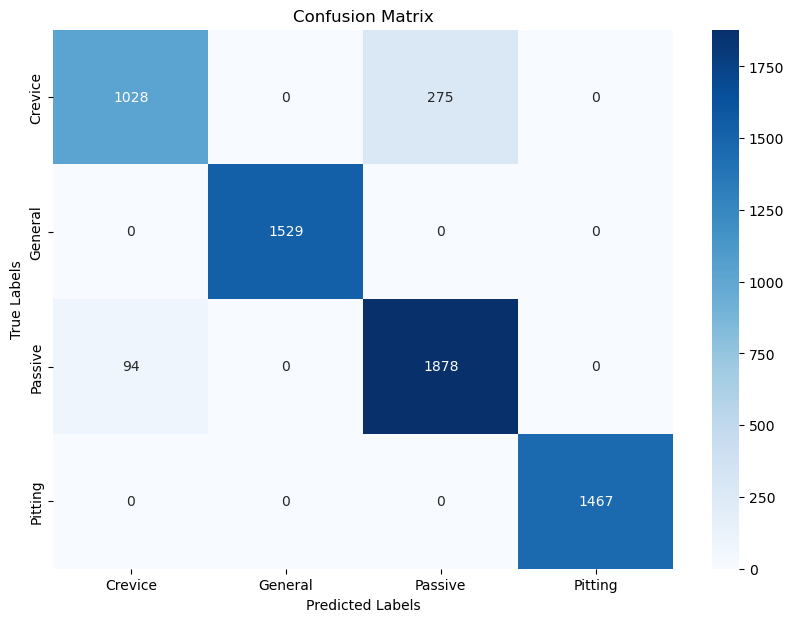

In [15]:
from tensorflow.keras.layers import Input, LSTM, SimpleRNN, Dense, RepeatVector, TimeDistributed, LeakyReLU

# Set random seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

# Load the data from CSV file
data = pd.read_csv('For classification-with one passive.csv')

# Extract the input features and labels
X = data[['WE(1).Current (A)', 'WE(1).Potential (V)']].values
y = data['Label'].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Create sequences
def create_sequences(data, labels, seq_length):
    X_seq, y_seq = [], []
    for i in range(0, len(data) - seq_length, seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(labels[i + seq_length - 1])
    return np.array(X_seq), np.array(y_seq)

seq_length = 20
X_seq, y_seq = create_sequences(X_scaled, y_encoded, seq_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=0)

# Build the LSTM autoencoder model
input_seq = Input(shape=(seq_length, X_train.shape[2]))
encoded = LSTM(50, activation='tanh', return_sequences=False)(input_seq)
decoded = RepeatVector(seq_length)(encoded)
decoded = LSTM(50, activation='tanh', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(X_train.shape[2]))(decoded)

autoencoder = Model(input_seq, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
history = autoencoder.fit(X_train, X_train, epochs=5, batch_size=32, validation_split=0.2, verbose=2)

# Encoder model to extract latent representations
encoder = Model(input_seq, encoded)

# Extract latent representations
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Reshape the latent representations to fit into the Simple RNN classifier
X_train_encoded_reshaped = X_train_encoded.reshape((X_train_encoded.shape[0], 1, X_train_encoded.shape[1]))
X_test_encoded_reshaped = X_test_encoded.reshape((X_test_encoded.shape[0], 1, X_test_encoded.shape[1]))

# Build the Simple RNN classifier model
classifier = Sequential()
classifier.add(SimpleRNN(50, activation='tanh', input_shape=(1, X_train_encoded.shape[1])))
classifier.add(Dense(len(np.unique(y_encoded)), activation='softmax'))

classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the Simple RNN classifier
classifier.fit(X_train_encoded_reshaped, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=2)

# Predict the cluster labels
y_train_pred = classifier.predict(X_train_encoded_reshaped)
y_test_pred = classifier.predict(X_test_encoded_reshaped)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Evaluate classification on the test set
accuracy = accuracy_score(y_test, y_test_pred_classes[:len(y_test)])
print(f'Classification Test Accuracy: {accuracy * 100:.2f}%')
print("Classification Report for LSTM Autoencoder with Simple RNN Classification:")
print(classification_report(y_test, y_test_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# LSTM autoencoder and GRU

Epoch 1/5
627/627 - 5s - 7ms/step - loss: 0.0196 - val_loss: 5.1711e-04
Epoch 2/5
627/627 - 4s - 6ms/step - loss: 4.7361e-04 - val_loss: 1.4771e-04
Epoch 3/5
627/627 - 4s - 6ms/step - loss: 2.4068e-04 - val_loss: 1.3781e-04
Epoch 4/5
627/627 - 4s - 6ms/step - loss: 2.4087e-04 - val_loss: 1.1860e-04
Epoch 5/5
627/627 - 3s - 6ms/step - loss: 1.7472e-04 - val_loss: 1.1581e-04
784/784 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
Epoch 1/5


/Library/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


627/627 - 1s - 1ms/step - accuracy: 0.7842 - loss: 0.4291 - val_accuracy: 0.8134 - val_loss: 0.3357
Epoch 2/5
627/627 - 0s - 492us/step - accuracy: 0.8434 - loss: 0.3306 - val_accuracy: 0.8970 - val_loss: 0.3027
Epoch 3/5
627/627 - 0s - 495us/step - accuracy: 0.9016 - loss: 0.2763 - val_accuracy: 0.9221 - val_loss: 0.2417
Epoch 4/5
627/627 - 0s - 490us/step - accuracy: 0.9326 - loss: 0.2259 - val_accuracy: 0.9386 - val_loss: 0.2156
Epoch 5/5
627/627 - 0s - 489us/step - accuracy: 0.9345 - loss: 0.2082 - val_accuracy: 0.9350 - val_loss: 0.2048
784/784 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
Classification Test Accuracy: 93.83%
Classification Report for LSTM Autoencoder with GRU Classification:
              precision    recall  f1-score   support

     Crevice       0.87      0.82      0.85      1303
     General       1.00      1.00      1.00      1529
     Passive       0.89      0.92      0.90      1972
     Pitting       1.00      1.00      1.00 

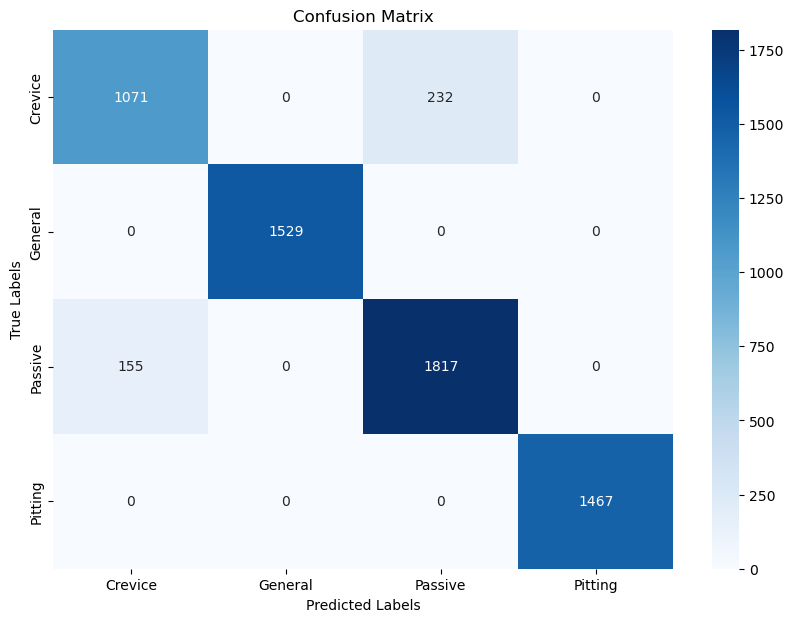

In [16]:
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, RepeatVector, TimeDistributed, LeakyReLU


# Set random seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

# Load the data from CSV file
data = pd.read_csv('For classification-with one passive.csv')

# Extract the input features and labels
X = data[['WE(1).Current (A)', 'WE(1).Potential (V)']].values
y = data['Label'].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Create sequences
def create_sequences(data, labels, seq_length):
    X_seq, y_seq = [], []
    for i in range(0, len(data) - seq_length, seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(labels[i + seq_length - 1])
    return np.array(X_seq), np.array(y_seq)

seq_length = 20
X_seq, y_seq = create_sequences(X_scaled, y_encoded, seq_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=0)

# Build the LSTM autoencoder model
input_seq = Input(shape=(seq_length, X_train.shape[2]))
encoded = LSTM(50, activation='tanh', return_sequences=False)(input_seq)
decoded = RepeatVector(seq_length)(encoded)
decoded = LSTM(50, activation='tanh', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(X_train.shape[2]))(decoded)

autoencoder = Model(input_seq, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
history = autoencoder.fit(X_train, X_train, epochs=5, batch_size=32, validation_split=0.2, verbose=2)

# Encoder model to extract latent representations
encoder = Model(input_seq, encoded)

# Extract latent representations
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Reshape the latent representations to fit into the GRU classifier
X_train_encoded_reshaped = X_train_encoded.reshape((X_train_encoded.shape[0], 1, X_train_encoded.shape[1]))
X_test_encoded_reshaped = X_test_encoded.reshape((X_test_encoded.shape[0], 1, X_test_encoded.shape[1]))

# Build the GRU classifier model
classifier = Sequential()
classifier.add(GRU(50, activation='tanh', input_shape=(1, X_train_encoded.shape[1])))
classifier.add(Dense(len(np.unique(y_encoded)), activation='softmax'))

classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the GRU classifier
classifier.fit(X_train_encoded_reshaped, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=2)

# Predict the cluster labels
y_train_pred = classifier.predict(X_train_encoded_reshaped)
y_test_pred = classifier.predict(X_test_encoded_reshaped)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Evaluate classification on the test set
accuracy = accuracy_score(y_test, y_test_pred_classes[:len(y_test)])
print(f'Classification Test Accuracy: {accuracy * 100:.2f}%')
print("Classification Report for LSTM Autoencoder with GRU Classification:")
print(classification_report(y_test, y_test_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
